In [1]:
from model_predictions import deepspcas9_predictions, rule_set2_predictions
from datasets import dataset_list
import pandas as pd
import joblib
import sglearn
import plotnine as gg
from scipy import stats
from tqdm import tqdm
import numpy as np


In [2]:
model = joblib.load('../models/RuleSet3.pkl')
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [3]:
dataset_activity_list = []
for ds in dataset_list:
    ds.load_data()
    dataset_activity = ds.get_sg_df(include_group=True,
                                    include_activity=True)
    dataset_activity['dataset'] = ds.name
    dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.825581,Aguirre2017
...,...,...,...,...,...,...
43854,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,0.250000,Wang2014
43855,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.808824,Wang2014
43856,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,0.125000,Wang2014
43857,TTTGTGTATTGCGGCAAGAA,CCAGTTTGTGTATTGCGGCAAGAAGGGTTA,GGG,RPL8,0.166667,Wang2014


In [4]:
model_prediction_list = [deepspcas9_predictions,
                         rule_set2_predictions]
for model_prediction in model_prediction_list:
    model_prediction.load_model_predictions()
    model_prediction.get_sgrnas()
    dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                    how='inner',
                                                    on=['sgRNA Sequence',
                                                        'sgRNA Context Sequence',
                                                        'PAM Sequence'])
    dataset_activity_df[model_prediction.name + ' train'] = (dataset_activity_df['sgRNA Sequence']
                                                             .isin(model_prediction.sgrnas))
dataset_activity_df


,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,DeepSpCas9,DeepSpCas9 train,Rule Set 2,Rule Set 2 train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,25.799622,False,0.489201,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,0.784734,False,0.464962,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,32.187088,False,0.525786,False
3,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.666667,Shalem_2014,32.187088,False,0.525786,False
4,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,19.478521,False,0.369761,False
...,...,...,...,...,...,...,...,...,...,...
43854,TTTGGACTGAAAGTGCTTTC,TGCATTTGGACTGAAAGTGCTTTCCGGAAG,CGG,RPL4,0.142857,Wang2014,18.558062,False,0.362297,False
43855,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,0.250000,Wang2014,10.168873,False,0.333939,False
43856,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.808824,Wang2014,49.501511,False,0.489867,False
43857,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,0.125000,Wang2014,40.421345,False,0.445911,False


In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

train_data_sgs = set()
for ds in train_data_list:
    ds.load_data()
    ds.get_sgrnas()
    train_data_sgs |= set(ds.sgrnas)

X = sglearn.featurize_guides(dataset_activity_df['sgRNA Context Sequence'])
dataset_activity_df['Rule Set 3'] = model.predict(X)
dataset_activity_df['Rule Set 3 train'] = dataset_activity_df['sgRNA Sequence'].isin(train_data_sgs)
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,DeepSpCas9,DeepSpCas9 train,Rule Set 2,Rule Set 2 train,Rule Set 3,Rule Set 3 train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,25.799622,False,0.489201,False,0.284257,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,0.784734,False,0.464962,False,0.183963,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,32.187088,False,0.525786,False,0.415110,False
3,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.666667,Shalem_2014,32.187088,False,0.525786,False,0.415110,False
4,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,19.478521,False,0.369761,False,0.158673,False
...,...,...,...,...,...,...,...,...,...,...,...,...
43854,TTTGGACTGAAAGTGCTTTC,TGCATTTGGACTGAAAGTGCTTTCCGGAAG,CGG,RPL4,0.142857,Wang2014,18.558062,False,0.362297,False,0.181926,True
43855,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,0.250000,Wang2014,10.168873,False,0.333939,False,0.241565,True
43856,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.808824,Wang2014,49.501511,False,0.489867,False,0.581885,True
43857,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,0.125000,Wang2014,40.421345,False,0.445911,False,0.421645,True


In [6]:
score_cols = ['Rule Set 3'] + [m.name for m in model_prediction_list]
guide_train_cols = [name + ' train' for name in score_cols]
filtered_predictions = dataset_activity_df[~dataset_activity_df[guide_train_cols].any(axis=1)].copy()
long_predictions = filtered_predictions.melt(id_vars=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                      'PAM Sequence', 'sgRNA Activity',
                                                      'sgRNA Target', 'dataset'],
                                             value_vars=score_cols,
                                             var_name='model',
                                             value_name='prediction')


In [27]:
performance_point_estimates =  (long_predictions.groupby(['dataset', 'model'])
                                .apply(lambda df: pd.Series(
    {'spearman': stats.spearmanr(df['prediction'], df['sgRNA Activity'])[0],
     'pearson': stats.pearsonr(df['prediction'], df['sgRNA Activity'])[0],
     'size': df.shape[0]}))
                                .reset_index())
nboots = 1000
bootstrap_prediction_list = []
for i in tqdm(range(nboots)):
    resampled_predictions = (long_predictions.groupby(['dataset', 'model'])
                             .sample(frac=1, replace=True,
                                     random_state=i))
    predictive_performance = (resampled_predictions.groupby(['dataset', 'model'])
                              .apply(lambda df: pd.Series(
        {'spearman': stats.spearmanr(df['prediction'], df['sgRNA Activity'])[0],
         'pearson': stats.pearsonr(df['prediction'], df['sgRNA Activity'])[0],
         'size': df.shape[0]}))
                              .reset_index())
    bootstrap_prediction_list.append(predictive_performance)

predictive_performance_ci = (pd.concat(bootstrap_prediction_list)
                             .reset_index(drop=True)
                             .groupby(['dataset', 'model'])
                             .agg(pearson_975 = ('pearson', lambda x: np.percentile(x, 97.5)),
                                  pearson_025 = ('pearson', lambda x: np.percentile(x, 2.5)),
                                  spearman_975 = ('spearman', lambda x: np.percentile(x, 97.5)),
                                  spearman_025 = ('spearman', lambda x: np.percentile(x, 2.5)))
                             .reset_index()
                             .merge(performance_point_estimates, how='inner',
                                    on=['dataset', 'model']))
predictive_performance_ci['dataset_name'] = (predictive_performance_ci['dataset'] + '\n(n = ' +
                                             predictive_performance_ci['size'].astype(int).astype(str) + ')')
dataset_size = (predictive_performance_ci[['dataset_name', 'size']].drop_duplicates()
                .sort_values('size', ascending=False))
predictive_performance_ci['dataset_name'] = pd.Categorical(predictive_performance_ci['dataset_name'],
                                                           categories=dataset_size['dataset_name'])
predictive_performance_ci['spearman_rank'] = (predictive_performance_ci.groupby('dataset')
                                              ['spearman']
                                              .rank())
model_avg_rank = (predictive_performance_ci.groupby('model')
                  .agg({'spearman_rank': 'mean'})
                  .reset_index()
                  .sort_values('spearman_rank'))
predictive_performance_ci['model'] = pd.Categorical(predictive_performance_ci['model'],
                                                    categories=model_avg_rank['model'])

100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]


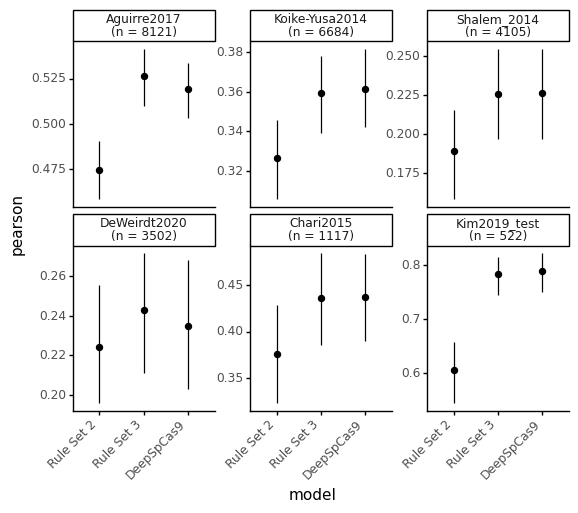

<ggplot: (8762684843216)>

In [28]:
(gg.ggplot(data=predictive_performance_ci) +
 gg.aes(x='model', y='pearson',
        ymin='pearson_025', ymax='pearson_975') +
 gg.geom_pointrange() +
 gg.facet_wrap('dataset_name', scales='free_y') +
 gg.theme_classic() +
 gg.theme(subplots_adjust={'wspace': 0.25},
          axis_text_x=gg.element_text(angle=45, hjust=1, vjust=1)))

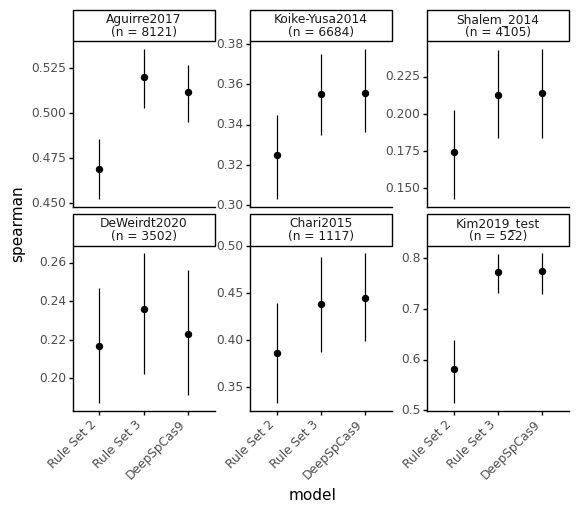

<ggplot: (8762687425350)>

In [29]:
(gg.ggplot(data=predictive_performance_ci) +
 gg.aes(x='model', y='spearman',
        ymin='spearman_025', ymax='spearman_975') +
 gg.geom_pointrange() +
 gg.facet_wrap('dataset_name', scales='free_y') +
 gg.theme_classic() +
 gg.theme(subplots_adjust={'wspace': 0.25},
          axis_text_x=gg.element_text(angle=45, hjust=1, vjust=1)))